For this task we used CTU scenario 43 (https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-43/)

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import time
from helper_functions.sketching import *

data = pd.read_csv('./data/capture20110811.pcap.netflow.labeled', sep ='\s+')
data.head()

infected_host = '147.32.84.165'

Some preprocessing; separating features `Src_IP_Addr:Port` and `Dst_IP_Addr:Port` into separate features for tuilized IP addresses and ports. Additioanally, discarding of some not-used features (e.g. `->` is discarded as we only considering unidirectional netflows).

In [2]:
data[['Src_IP_Addr', 'Src_Port']] = data['Src_IP_Addr:Port'].str.split(':', n=1, expand=True)
data[['Dst_IP_Addr', 'Dst_Port']] = data['Dst_IP_Addr:Port'].str.split(':', n=1, expand=True)

data['Label'] = data['Label(LEGITIMATE:Botnet:Background)']

data = data.drop(labels=['->', 'Label(LEGITIMATE:Botnet:Background)', 'Src_IP_Addr:Port', 'Dst_IP_Addr:Port'], axis=1)

data.head()

,#Date_flow,start,Durat,Prot,Flags,Tos,Packets,Bytes,Flows,Src_IP_Addr,Src_Port,Dst_IP_Addr,Dst_Port,Label
0,2011-08-11,10:10:00.003,0.967,UDP,INT,0,2,135,1,89.31.8.11,23929,147.32.84.229,13363,Background
1,2011-08-11,10:10:00.003,0.967,UDP,INT,0,2,276,1,147.32.84.229,13363,89.31.8.11,23929,Background
2,2011-08-11,10:10:00.006,0.000,UDP,INT,0,1,62,1,208.88.186.6,34042,147.32.84.229,13363,Background
3,2011-08-11,10:10:00.008,0.000,UDP,INT,0,1,78,1,92.118.218.77,55246,147.32.84.229,13363,Background
4,2011-08-11,10:10:00.009,0.000,UDP,INT,0,1,72,1,182.185.139.181,10223,147.32.84.229,13363,Background


The infected host documented in the dataset (https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-43/) is 147.32.84.165. We want now to examine the hosts, that host connects with; we are thus going to consider netflows where this host appears either as source or destination.

In [3]:
comm_hosts = []

hosts = data[data['Src_IP_Addr']==infected_host]['Dst_IP_Addr'].values
comm_hosts.append(hosts)

hosts = data[data['Dst_IP_Addr']==infected_host]['Src_IP_Addr'].values
comm_hosts.append(hosts)
comm_hosts = [x for sublist in comm_hosts for x in sublist]
total_count = len(comm_hosts)

ground_truth = pd.DataFrame(comm_hosts, columns=['IP_Addr'])
ground_truth = ground_truth.groupby('IP_Addr').size()
ground_truth = ground_truth/total_count
ground_truth = ground_truth.sort_values(ascending=False)
unique_comm_hosts = np.array(ground_truth.index)

ground_truth.head(10)

IP_Addr
193.23.181.44      0.118347
174.128.246.102    0.075340
174.37.196.55      0.068102
173.236.31.226     0.062646
184.154.89.154     0.061433
67.19.72.206       0.059229
46.4.36.120        0.057869
72.20.15.61        0.057153
147.32.80.9        0.028898
212.117.171.138    0.017765
dtype: float64

Here we have an "interactive visualizer". You can adjust `topN` and the counts of the topN most frequent hosts will be visualized. Here we present the distribution for `topN=10`.

Text(0, 0.5, 'Frequency')

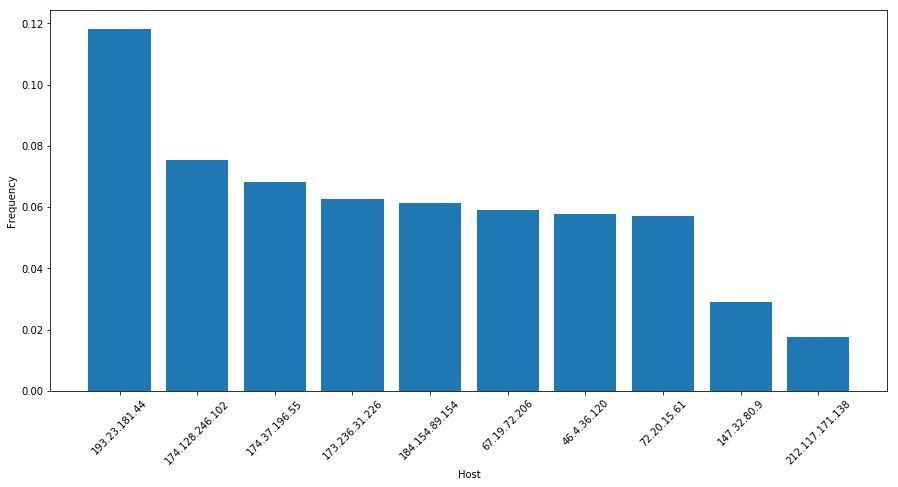

In [4]:
import seaborn as sns

topN=10

plt.figure(figsize=(15,7))
plt.bar(range(topN), ground_truth.head(topN).values)
plt.xticks(range(topN), ground_truth.head(topN).index, rotation=45)

plt.xlabel('Host')
plt.ylabel('Frequency')

Here COUNT-MIN sketch is performed for various values of depths and widths. For more information about the used helper functions please refer to `helper_functions/sketching.py`.

Extracted results are stored into dictionaries; for each combination of depth-width the IPs with the respective counts are stored in `dic`, the respective execution time in `dur_dic`. The dictionary `enum` is just an enumeration of the tested combinations, for easier access of the aforementioned dictionaries.

In [5]:
depths = np.array([5, 10, 20, 50], dtype=int)
widths = np.array([10, 100, 1000])

enum = {}
dic = {}
dur_dic = {}

i = 0
for d in depths:
    for w in widths:
        # Start timer
        start_time = time.time()
        
        cm, seeds = construct_cm(comm_hosts, d, w)
        cm = cm/total_count
        estim_count = estimate_counts(unique_comm_hosts, cm, seeds)
        sorted_ind = np.flip(np.argsort(estim_count))
        
        # Stop timer and extract duration
        dur = time.time() - start_time
        
        # Pass the results into dictionaries
        enum[i] = f'd_{d}-w_{w}'
        dic[f'd_{d}-w_{w}'] = {'IP_Addr':unique_comm_hosts[sorted_ind], 'Frequency':estim_count[sorted_ind]}
        dur_dic[f'd_{d}-w_{w}'] = dur
        
        i = i+1
        

print("Total duration in seconds: ", np.sum(list(dur_dic.values())))

Total duration in seconds:  14.17186689376831


Now in order to compare the results we repeat our ground truth here, that is the top-10 IPs with their repsective counts.

In [6]:
ground_truth.head(10)

IP_Addr
193.23.181.44      0.118347
174.128.246.102    0.075340
174.37.196.55      0.068102
173.236.31.226     0.062646
184.154.89.154     0.061433
67.19.72.206       0.059229
46.4.36.120        0.057869
72.20.15.61        0.057153
147.32.80.9        0.028898
212.117.171.138    0.017765
dtype: float64

For `depth=5` and `width=1000` we see that the play correctly identifies the top-10 IPs with the correct order, with minor divergences of the computed counts, from the actual ones. This is of course attributed to the low value of depth and consequently the few hash functions utilized.

In [7]:
df = pd.DataFrame(data=dic[enum[2]])
df.set_index('IP_Addr', inplace=True)
df.head(10)

,Frequency
IP_Addr,
193.23.181.44,0.118439
174.128.246.102,0.075377
174.37.196.55,0.068102
173.236.31.226,0.062646
184.154.89.154,0.061452
67.19.72.206,0.059266
46.4.36.120,0.057888
72.20.15.61,0.057171
147.32.80.9,0.028971


By increasing now the `depth=10` and `width=1000` we extract the correct top-10 IPs with their respective counts!

In [8]:
df = pd.DataFrame(data=dic[enum[5]])
df.set_index('IP_Addr', inplace=True)
df.head(10)

,Frequency
IP_Addr,
193.23.181.44,0.118347
174.128.246.102,0.075340
174.37.196.55,0.068102
173.236.31.226,0.062646
184.154.89.154,0.061452
67.19.72.206,0.059229
46.4.36.120,0.057869
72.20.15.61,0.057153
147.32.80.9,0.028898


If we decrease the width, hash functions map mulitple IPs to the same cells, thus leading to overlapping counts. This may be seen from the following example where `depth=5` and `width=10`; IPs are not correctly identified, although there are still some of the actual top-10 in the extracted top.

In [9]:
df = pd.DataFrame(data=dic[enum[0]])
df.set_index('IP_Addr', inplace=True)
df.head(10)

,Frequency
IP_Addr,
193.23.181.44,0.151893
61.89.186.155,0.145482
60.173.109.42,0.145482
203.228.172.80,0.142395
66.111.4.73,0.133265
85.158.228.111,0.116969
64.18.7.13,0.116969
203.183.218.25,0.116969
209.240.204.25,0.113865


Here we evaluate the sketches played; we extract recall values, that is how many IPs of the top-10 ground-truth are found in the extracted top-10 play. Additionally, we compute the divergence of frequencies computed; for each IP of ground-truth top-10 occuring also at the top-10 play we compute the absolute difference of the frequencies; in case the IP is missing from the top-10 play only the respective ground-truth frequency is added.

For `widths=10,100` all IPs are correctly identified. As more hash functions are used an doverlap is reduced, the frequency distance also drops, with `depth=50` and `width=1000`, we have a perfect of IPs and corresponding frequencies.

In [10]:
n = len(dic)
rec = np.zeros(n)
dis = np.zeros(n)
for i in range(len(dic)):
    df = pd.DataFrame(data=dic[enum[i]])
    df.set_index('IP_Addr', inplace=True)
    
    rec[i], dis[i] = evaluate(ground_truth.head(10), df.head(10))
    
print("Recall values: ", rec)
print("Divergence: ", dis)

Recall values:  [0.1 1.  1.  0.8 1.  1.  0.9 1.  1.  0.9 1.  1. ]
Divergence:  [5.21981151e-01 7.47708192e-03 2.93939338e-04 3.43688571e-01
 6.31969577e-03 3.67424173e-05 2.47662264e-01 6.66874874e-03
 3.67424173e-05 2.08954127e-01 5.19905205e-03 0.00000000e+00]


Finally a visualization for the execution time versus `depth` and `width`. In the following visualization rows correspond to depth values and columns to width values.

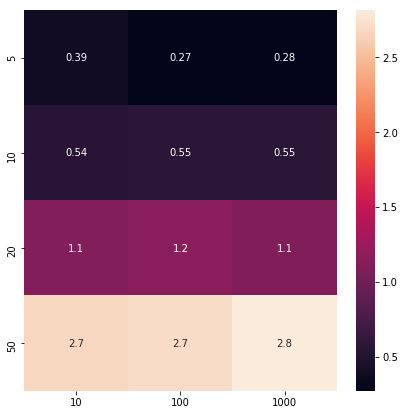

In [11]:
dur = np.reshape(list(dur_dic.values()), [4,3])
dur = np.round(dur, 4)

fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(dur, annot=True, xticklabels=widths, yticklabels=depths, ax=ax)